## A classic problem

Here I'm going to consider the half-pipe problem seen in Classical Mechanics by Taylor, Example 1.2. It consists of a skateboard in a semicircular half-pipe that is released at some angle $\phi$ from equilibrium position. This problem is analogous to many others in classical mechanics, like the simple pendulum problem, a mass on a spring, etc. For the moment, we'll neglect friction. 

Through a straightforward analysis of the forces, we can arrive at the equation of motion for the angle the skateboard makes with the bottom of the pipe:

\begin{equation} \tag{1}
\ddot{\phi} = -\frac{g}{R}\sin (\phi)
\end{equation}

where $g$ is the gravitational constant, and $R$ is the radius of the pipe. 

This differential equation has no solution in terms of commonly known elementary functions (though complex analysis says otherwise - see 
[this](https://mathworld.wolfram.com/JacobiEllipticFunctions.html) and [this](https://en.wikipedia.org/wiki/Jacobi_elliptic_functions#Jacobi_elliptic_functions_as_solutions_of_nonlinear_ordinary_differential_equations)).
However, using the small angle approximation, we can approximate the sine as $\sin(\phi) \approx \phi$, so that the equation becomes

\begin{equation} \tag{2}
\ddot{\phi} = - \frac{g}{R}\phi
\end{equation}

This has the well-known solution consisting of sines and cosines: $\phi(t) = A\sin(\omega_0 t) + B\cos(\omega_0 t)$, with $A$ and $B$ being constants determined by the boundary conditions of the system, and $\omega^2 = \frac{g}{R}$ being the natural frequency of oscillations. In particular, if we let the release angle be $\phi(0)=\phi_0$ and the initial velocity $\dot{\phi}(0) = 0$, we have the solution 

\begin{align*}
\phi(t) = \phi_0\cos(\omega t)
\end{align*}

(note that, more generally, for a nonzero initial velocity $\omega_0$, $A = \frac{\omega_0}{\omega}$, and $\phi(t) = \phi_0 \cos(\omega t) + \frac{\omega_0}{\omega} \sin(\omega t)$.)

In the following, I will be using numerical integration (Runge Kutta 4) to compare the solution provided by the small angle approximation from Equation 2 to the numerical solution to the nonlinear Equation 1. 

We can define a state vector $\mathbf{q}(t)$ such that

\begin{align*}
\mathbf{q}(t) = 
\begin{bmatrix}
q_1(t) \\
q_2(t)
\end{bmatrix}
= 
\begin{bmatrix}
\phi(t) \\
\dot{\phi}(t)
\end{bmatrix}
\implies
\dot{\mathbf{q}}(t) = 
\begin{bmatrix}
\dot{\phi}(t) \\
\ddot{\phi}(t)
\end{bmatrix}
= 
\begin{bmatrix}
\dot{\phi}(t) \\
-\frac{g}{R}\sin(t)
\end{bmatrix}
\end{align*}

If we define $\mathbf{A}$ and $\mathbf{B}$ as 

\begin{align*}
\mathbf{A} = 
\begin{bmatrix}
0 & 1 \\
0 & 0 
\end{bmatrix}, 

\mathbf{B} = 
\begin{bmatrix}
0 \\
1
\end{bmatrix}
\end{align*}

we find 

\begin{align*}
\dot{\mathbf{q}}(t) = \mathbf{A}\mathbf{q}(t) - \frac{g}{R}\sin(\phi(t)) \mathbf{B}
\end{align*}

This we can integrate using the methods presented [here](https://lpsa.swarthmore.edu/NumInt/NumIntIntro.html) and elsewhere.

In [8]:
import numpy as np
import sympy as sp
import scipy as sc
import matplotlib.pyplot as plt
import ipywidgets as wd

def smallAngle(A, B, omega, t):
    return A*np.sin(omega*t) + B*np.sin(omega*t)

def rk4(A, B, q0, gamma, t, h, params):
    #this is a function specific to our system, where gamma is our driving force dependent on q
    #need to work on a more general one - maybe the scipy api has one...
    q = np.zeros((len(B), len(t))) #length of B sets the dimension of the system
    q[:, 0] = q0
    for i in range(len(t)-1):

        k1 = A @ q[:, i] + B*gamma(params[0], q[0,i], t)
        y1 = q[:, i] + k1*h/2

        k2 = A @ y1 + B*gamma(params[0], q[0,i], t)
        y2 = q[:, i] + k2*h/2

        k3 = A @ y2 + B*gamma(params[0], q[0,i], t)
        y3 = q[:, i] + k3*h

        k4 = A @ y3 + B*gamma(params[0], q[0,i], t)
        q[:, i+1] = q[:, i] + (k1 + 2*k2 + 2*k3 + k4)*h/6
    return q

def gammaRamp(p, x, y):
    return -np.sin(x)*p**2


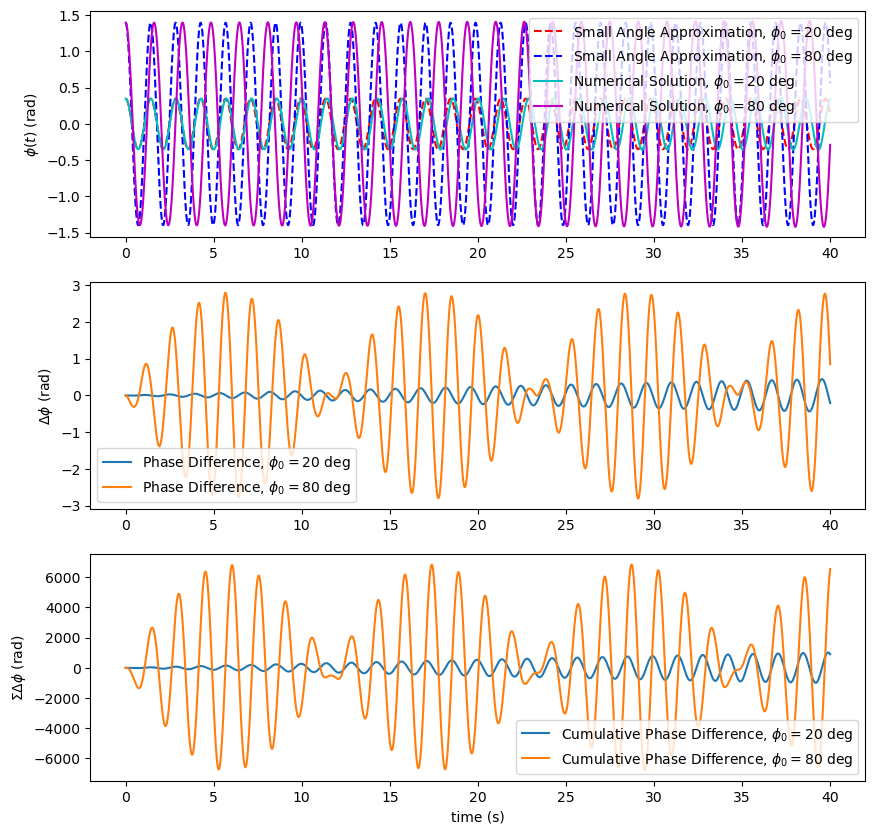

In [26]:
phi0 = 20*np.pi/180 #initial angle, phi
phiDot0 = 0 #initial velocity
g = 9.8 #m/s2, gravity
R = 0.5 #m, radius of pipe
h = 0.0001 #time step
omega = np.sqrt(g/R)

#initial state vector
q0 = np.array([
    phi0, phiDot0
]) 

t = np.arange(0, 40 + h, step=h)

#small angle approximation
phiExact20 = 20*(np.pi/180)*np.cos(omega*t)
phiExact80 = 80*(np.pi/180)*np.cos(omega*t)

A = np.array([ 
    [0, 1],
    [0, 0]
]) #coefficient matrix

B = np.array([0, 1]) #input matrix

#run the computation for different initial conditions
q20 = rk4(A, B, np.array([20*np.pi/180, 0]), gammaRamp, t, h, [omega])
q80 = rk4(A, B, np.array([80*np.pi/180, 0]), gammaRamp, t, h, [omega])

#determine the phase difference and cumulative phase difference
delta20 = phiExact20 - q20[0, :]
cumDelta20 = np.cumsum(delta20)

delta80 = phiExact80 - q80[0, :]
cumDelta80 = np.cumsum(delta80)


fig, ax = plt.subplots(3,1, figsize=(10, 10))
ax[0].plot(t, phiExact20, label='Small Angle Approximation, $\\phi_0 = 20$ deg', c='r', ls='--')
ax[0].plot(t, phiExact80, label='Small Angle Approximation, $\\phi_0 = 80$ deg', c='b', ls='--')
ax[0].plot(t, q20[0,:], label='Numerical Solution, $\\phi_0 = 20$ deg', c='c')
ax[0].plot(t, q80[0,:], label='Numerical Solution, $\\phi_0 = 80$ deg', c='m')


ax[0].set_ylabel('$\\phi(t)$ (rad)')
#ax[0].set_xlabel('time (s)')

ax[1].plot(t, delta20, label='Phase Difference, $\\phi_0 = 20$ deg')
ax[1].plot(t, delta80, label='Phase Difference, $\\phi_0 = 80$ deg')

ax[1].set_ylabel('$\\Delta \\phi$ (rad)')

#ax[1].set_xlabel('time (s)')


ax[2].plot(t, cumDelta20, label='Cumulative Phase Difference, $\\phi_0 = 20$ deg')
ax[2].plot(t, cumDelta80, label='Cumulative Phase Difference, $\\phi_0 = 80$ deg')

ax[2].set_ylabel('$\\Sigma \\Delta \\phi$ (rad)')
ax[2].set_xlabel('time (s)')

for a in ax: 
    a.legend()

plt.show()
fig.tight_layout()